# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [74]:
# Import libraries

from pyspark.sql import SparkSession, Window
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import udf, first, last, col, countDistinct, format_number
from pyspark.ml.feature import MinMaxScaler ,VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark import PickleSerializer

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# Create a Spark session

spark = SparkSession \
    .builder \
    .appName("Sparkify Project") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
# Load events data from json file

events_df = spark.read.json("mini_sparkify_event_data.json")

In [4]:
# View some sample event records

events_df.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

In [5]:
# View list of columns available

events_df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
# How many records in our sample

events_df.count()

286500

In [7]:
# View list of event page values

events_df.select("page").dropDuplicates().sort("page").show(100)

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|               Login|
|              Logout|
|            NextSong|
|            Register|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
| Submit Registration|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



In [8]:
# View list of event page values by count

events_df.groupBy('page').count().orderBy('count').show()

+--------------------+-----+
|                page|count|
+--------------------+-----+
| Submit Registration|    5|
|            Register|   18|
|              Cancel|   52|
|Cancellation Conf...|   52|
|    Submit Downgrade|   63|
|      Submit Upgrade|  159|
|               Error|  258|
|       Save Settings|  310|
|             Upgrade|  499|
|               About|  924|
|            Settings| 1514|
|                Help| 1726|
|           Downgrade| 2055|
|         Thumbs Down| 2546|
|              Logout| 3226|
|               Login| 3241|
|         Roll Advert| 3933|
|          Add Friend| 4277|
|     Add to Playlist| 6526|
|           Thumbs Up|12551|
+--------------------+-----+
only showing top 20 rows



In [9]:
# Check if any records have userId or sessionId value of null

events_df.dropna(how = "any", subset = ["userId", "sessionId"]).count()

286500

---> This is the same as the total record count, therefore we note there are no rows where userId or sessionId is null.

In [10]:
# Remove rows where user is anonymous and is not logged in - only care about users we can identify

events_df = events_df.filter(events_df["userId"] != "")
events_df.count()

278154

**---> Number of records is now lower. We have removed records where the user was anonymous.**

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

In [11]:
# Count number of unique users
events_df.agg(countDistinct('userId')).show()

+----------------------+
|count(DISTINCT userId)|
+----------------------+
|                   225|
+----------------------+



In [12]:
# Add churnEvent flag when Cancellation Confirmation has occurred

flag_downgrade_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
events_df = events_df.withColumn("churnEvent", flag_downgrade_event("page"))

In [13]:
# Check churnEvent records now exist
events_df.groupBy('churnEvent').count().show()

+----------+------+
|churnEvent| count|
+----------+------+
|         1|    52|
|         0|278102|
+----------+------+



In [14]:
# Get list of churned users
churned_users_df = events_df.select("userId", "churnEvent")\
    .where(events_df.churnEvent == 1).dropDuplicates().withColumnRenamed("churnEvent", "churnUser")

churned_users_df.show(10)

+------+---------+
|userId|churnUser|
+------+---------+
|100005|        1|
|300007|        1|
|100011|        1|
|100012|        1|
|   101|        1|
|100014|        1|
|200001|        1|
|   105|        1|
|     3|        1|
|100023|        1|
+------+---------+
only showing top 10 rows



In [15]:
# Add column to events_df to indicate whether churned user
events_df = events_df.join(churned_users_df, "userId", "outer")
events_df = events_df.fillna(0, subset="churnUser")
events_df.show(5)

+------+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+---------+-------------+---------+--------------------+------+-------------+--------------------+----------+---------+
|userId|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|     page| registration|sessionId|                song|status|           ts|           userAgent|churnEvent|churnUser|
+------+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+---------+-------------+---------+--------------------+------+-------------+--------------------+----------+---------+
|100010|Sleeping With Sirens|Logged In| Darianna|     F|            0|Carpenter|202.97098| free|Bridgeport-Stamfo...|   PUT| NextSong|1538016340000|       31|Captain Tyin Knot...|   200|1539003534000|"Mozilla/5.0 (iPh...|         0|        0|
|100010|Francesca Battist...

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

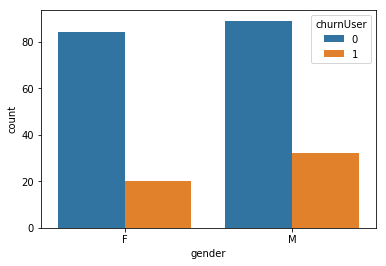

In [16]:
# Look at relative churn by gender
user_gender_df = events_df.select(["userId", "churnUser", "gender"]).dropDuplicates()

sns.countplot(data=user_gender_df.toPandas(), x="gender", hue="churnUser")

**---> Churn profile appears similar for Male versus Female, with slightly higher churn percentage for Male.**

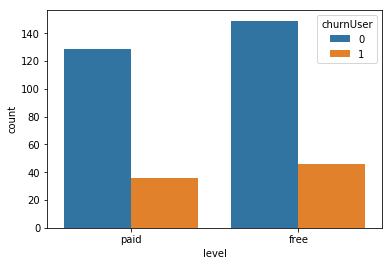

In [17]:
# Look at relative churn by level
user_lvl_df = events_df.select(["userId", "churnUser", "level"]).dropDuplicates()

sns.countplot(data=user_lvl_df.toPandas(), x="level", hue="churnUser")

**---> Churn profile is similar for Paid and Free customers.**

In [18]:
# Make events dataframe available to SQL

events_df.createOrReplaceTempView("events")

In [19]:
# Calculate songs and artists listened to per day for all uaers
# Timestamp "ts" is in milliseconds
# Account age will be the max timestamp minus the min timestamp
# Use factor 24*60*60*1000 to get account age in days

songs_artists_df = spark.sql("""
    SELECT userId,
        churnUser AS churn,
        COUNT(DISTINCT song)*24*60*60*1000 / (MAX(ts) - MIN(ts)) AS songsPerDay,
        COUNT(DISTINCT artist)*24*60*60*1000 / (MAX(ts) - MIN(ts)) AS artistsPerDay
    FROM events
    GROUP BY userId, churnUser
    """)

songs_artists_df.show()

+------+-----+------------------+------------------+
|userId|churn|       songsPerDay|     artistsPerDay|
+------+-----+------------------+------------------+
|    19|    0| 332.6014882487291| 313.5047520813379|
|300007|    1|344.45801307377343|332.04511170174555|
|100005|    1| 8.447798774292087|  8.22694128999687|
|200007|    0|2.1324439037392953|2.0996370744509982|
|200002|    0| 8.308275611535608|7.4510725722501885|
|    50|    0| 8.301561387275395| 7.377227871465321|
|    30|    0|20.853238480567068|16.689148406617353|
|     8|    0|4.7918836924435135| 4.516939546155771|
|100012|    1|15.563420045967504|13.639465249998011|
|100011|    1| 356.8907247465265| 356.8907247465265|
|     4|    0|29.669140342110115|22.132288126243342|
|    65|    0|31.279244821192115| 23.44666310222185|
|   101|    1|101.37766777191426| 78.23985429412039|
|    13|    0| 19.68136139220561|15.613992086557653|
|   153|    0|39.870895339858905| 33.28713317634872|
|100014|    1| 6.012942846006174|  5.649256786

In [20]:
# Look at average songs and artists per day versus churn
songs_artists_df.groupBy('churn').avg('songsPerDay', 'artistsPerDay').show()

+-----+----------------+------------------+
|churn|avg(songsPerDay)|avg(artistsPerDay)|
+-----+----------------+------------------+
|    1|72.0604862381857| 67.20742535555526|
|    0|37.7352567773026|33.228669029410725|
+-----+----------------+------------------+



**---> Looks like churned users listen to roughly twice as many songs and artists per day compared with unchurned users.**

In [21]:
# Calculate average session duration in minutes for each user
# Timestamp "ts" is in milliseconds

user_session_duration_df = spark.sql("""
    SELECT ssn.userId,
        churn,
        AVG(ssn.sessionDuration) AS sessionDuration
    FROM (
        SELECT userId,
            churnUser AS churn,
            sessionId,
            (MAX(ts) - MIN(ts))/(60*1000) AS sessionDuration
        FROM events
        GROUP BY userId, churnUser, sessionId
    ) AS ssn
    GROUP BY ssn.userId, churn
    """)

user_session_duration_df.show()

+------+-----+------------------+
|userId|churn|   sessionDuration|
+------+-----+------------------+
|    19|    0| 904.8666666666667|
|200007|    0| 90.11111111111113|
|100005|    1|120.18666666666665|
|300007|    1|464.03333333333336|
|200002|    0|266.40000000000003|
|    50|    0|           264.275|
|    30|    0|183.59427083333333|
|100012|    1| 271.4380952380953|
|     8|    0|146.88095238095238|
|100011|    1| 44.38333333333333|
|     4|    0| 379.3386363636364|
|    65|    0| 384.1746376811595|
|    13|    0|154.60757575757577|
|   101|    1|            817.58|
|   153|    0|437.12222222222226|
|    42|    0|329.56276595744686|
|100014|    1| 184.8138888888889|
|    94|    0|100.79722222222222|
|    62|    0| 816.8979166666667|
|   114|    0| 318.0705882352941|
+------+-----+------------------+
only showing top 20 rows



In [22]:
# Look at average session duration versus churn
user_session_duration_df.groupBy('churn').avg('sessionDuration').show()

+-----+--------------------+
|churn|avg(sessionDuration)|
+-----+--------------------+
|    1|  259.57453028914773|
|    0|   296.7599470605086|
+-----+--------------------+



**---> Churned users have slightly lower session durations compared with unchurned users.**

In [23]:
# Get page counts by user for a subset of page types that may be of interest
# We're only selecting page types here that we believe will be relevant

page_counts_df = spark.sql(
    "SELECT userId,\
        churnUser AS churn,\
        page,\
        COUNT(*) AS pageCount\
    FROM events\
    WHERE page IN (\
        'Add Friend',\
        'Add to Playlist',\
        'Help',\
        'Login',\
        'Logout',\
        'NextSong',\
        'Roll Advert',\
        'Settings',\
        'Thumbs Down',\
        'Thumbs Up')\
    GROUP BY userId, churnUser, page\
    ORDER BY 1,3")

page_counts_df.show()

+------+-----+---------------+---------+
|userId|churn|           page|pageCount|
+------+-----+---------------+---------+
|    10|    0|     Add Friend|       12|
|    10|    0|Add to Playlist|        9|
|    10|    0|           Help|        1|
|    10|    0|         Logout|       11|
|    10|    0|       NextSong|      673|
|    10|    0|    Roll Advert|        1|
|    10|    0|       Settings|        7|
|    10|    0|    Thumbs Down|        4|
|    10|    0|      Thumbs Up|       37|
|   100|    0|     Add Friend|       49|
|   100|    0|Add to Playlist|       61|
|   100|    0|           Help|       18|
|   100|    0|         Logout|       35|
|   100|    0|       NextSong|     2682|
|   100|    0|    Roll Advert|       25|
|   100|    0|       Settings|       11|
|   100|    0|    Thumbs Down|       27|
|   100|    0|      Thumbs Up|      148|
|100001|    1|     Add Friend|        2|
|100001|    1|Add to Playlist|        3|
+------+-----+---------------+---------+
only showing top

In [24]:
# Calculate days active for all users
# Timestamp "ts" is in milliseconds

days_active_df = spark.sql(
    "SELECT userId,\
        (MAX(ts) - MIN(ts))/(24*60*60*1000) AS daysActive\
    FROM events\
    GROUP BY userId")

days_active_df.show()

+------+-------------------+
|userId|         daysActive|
+------+-------------------+
|100010|  44.21780092592593|
|200002| 45.496805555555554|
|   125|0.02053240740740741|
|   124| 59.996944444444445|
|    51| 15.779398148148148|
|     7| 50.784050925925925|
|    15|  54.77318287037037|
|    54|  42.79719907407407|
|   155|  25.82783564814815|
|100014| 41.244363425925926|
|   132|  50.49740740740741|
|   154| 24.986458333333335|
|   101| 15.861481481481482|
|    11| 53.241585648148146|
|   138|  56.07674768518518|
|300017|  59.11390046296296|
|100021| 45.457256944444445|
|    29|  43.32092592592593|
|    69|  50.98648148148148|
|   112|  56.87869212962963|
+------+-------------------+
only showing top 20 rows



In [25]:
# Divide page counts by days active to get pages per day of each type

page_counts_df = page_counts_df.join(days_active_df, "userId", "inner")
page_counts_df = page_counts_df.withColumn('pagesPerDay', page_counts_df.pageCount / page_counts_df.daysActive)
page_counts_df.show()

+------+-----+---------------+---------+-------------------+-------------------+
|userId|churn|           page|pageCount|         daysActive|        pagesPerDay|
+------+-----+---------------+---------+-------------------+-------------------+
|100010|    0|     Add Friend|        4|  44.21780092592593|0.09046130554300602|
|100010|    0|Add to Playlist|        7|  44.21780092592593|0.15830728470026054|
|100010|    0|           Help|        2|  44.21780092592593|0.04523065277150301|
|100010|    0|         Logout|        5|  44.21780092592593|0.11307663192875753|
|100010|    0|       NextSong|      275|  44.21780092592593|  6.219214756081664|
|100010|    0|    Roll Advert|       52|  44.21780092592593| 1.1759969720590784|
|100010|    0|    Thumbs Down|        5|  44.21780092592593|0.11307663192875753|
|100010|    0|      Thumbs Up|       17|  44.21780092592593| 0.3844605485577756|
|200002|    0|     Add Friend|        4| 45.496805555555554|0.08791826043953026|
|200002|    0|Add to Playlis

In [26]:
# Pivot and aggregate across all users to get page rates for churned and unchurned users

page_rate_churn_pivot = page_counts_df.groupBy('page').pivot('churn').avg('pagesPerDay')

page_rate_churn_pivot = page_rate_churn_pivot.withColumnRenamed('0', 'no_churn')
page_rate_churn_pivot = page_rate_churn_pivot.withColumnRenamed('1', 'churn')

page_rate_churn_pivot.show()

+---------------+-------------------+------------------+
|           page|           no_churn|             churn|
+---------------+-------------------+------------------+
|    Thumbs Down|0.38293079179123285|1.9586845420537815|
|    Roll Advert|  2.322173563830428| 7.421197238752865|
|         Logout| 0.6232522709436888|0.9897750320170381|
|       Settings| 1.6359780188628494| 2.646798254413769|
|Add to Playlist| 1.1067587873838935| 2.934686315424889|
|     Add Friend| 0.6927238019914513|2.3511324917873107|
|       NextSong|  40.20637559224469| 74.53310132166251|
|      Thumbs Up| 1.9609748660000539| 4.880878647903342|
|           Help|0.26372036479048094|0.3270910329069824|
+---------------+-------------------+------------------+



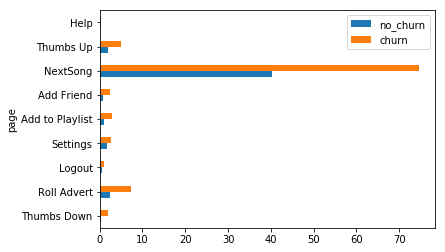

In [27]:
page_rate_churn_pivot.toPandas().plot(kind="barh", x="page")

**---> Users who churn play more songs per day and also engage more across other page features.**

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

<b>We plan to use the following input features:
- gender
- level
- sessionDuration
- songsPerDay
- artistsPerDay
- pgRateAddFriend
- pgRateAddtoPlaylist
- pgRateHelp
- pgRateLogout
- pgRateNextSong
- pgRateRollAdvert
- pgRateSettings
- pgRateThumbsDown
- pgRateThumbsUp</b>

In [28]:
user_page_count_pivot = page_counts_df.groupBy('userId', 'churn').pivot('page',\
        ['Add Friend',\
        'Add to Playlist',\
        'Help',\
        'Logout',\
        'NextSong',\
        'Roll Advert',\
        'Settings',\
        'Thumbs Down',\
        'Thumbs Up']\
).sum('pagesPerDay')

user_page_count_pivot = user_page_count_pivot.fillna(0)
user_page_count_pivot.show(5)

+------+-----+-------------------+-------------------+-------------------+-------------------+------------------+-------------------+-------------------+-------------------+------------------+
|userId|churn|         Add Friend|    Add to Playlist|               Help|             Logout|          NextSong|        Roll Advert|           Settings|        Thumbs Down|         Thumbs Up|
+------+-----+-------------------+-------------------+-------------------+-------------------+------------------+-------------------+-------------------+-------------------+------------------+
|100010|    0|0.09046130554300602|0.15830728470026054|0.04523065277150301|0.11307663192875753| 6.219214756081664| 1.1759969720590784|                0.0|0.11307663192875753|0.3844605485577756|
|200002|    0|0.08791826043953026|0.17583652087906051|0.04395913021976513|0.10989782554941281| 8.506091697524552|0.15385695576917793|0.06593869532964769|0.13187739065929538|0.4615708673075338|
|   125|    1|                0.0| 

In [29]:
user_page_rate_df = user_page_count_pivot.toDF(
    'userId',
    'churn',
    'pgRateAddFriend',
    'pgRateAddtoPlaylist',
    'pgRateHelp',
    'pgRateLogout',
    'pgRateNextSong',
    'pgRateRoll Advert',
    'pgRateSettings',
    'pgRateThumbsDown',
    'pgRateThumbsUp')

user_page_rate_df.show(5)

+------+-----+-------------------+-------------------+-------------------+-------------------+------------------+-------------------+-------------------+-------------------+------------------+
|userId|churn|    pgRateAddFriend|pgRateAddtoPlaylist|         pgRateHelp|       pgRateLogout|    pgRateNextSong|  pgRateRoll Advert|     pgRateSettings|   pgRateThumbsDown|    pgRateThumbsUp|
+------+-----+-------------------+-------------------+-------------------+-------------------+------------------+-------------------+-------------------+-------------------+------------------+
|100010|    0|0.09046130554300602|0.15830728470026054|0.04523065277150301|0.11307663192875753| 6.219214756081664| 1.1759969720590784|                0.0|0.11307663192875753|0.3844605485577756|
|200002|    0|0.08791826043953026|0.17583652087906051|0.04395913021976513|0.10989782554941281| 8.506091697524552|0.15385695576917793|0.06593869532964769|0.13187739065929538|0.4615708673075338|
|   125|    1|                0.0| 

In [30]:
# Encode free/paid level value as binary flag

levelFlag = udf(lambda x: 1 if x == "paid" else 0, IntegerType())
all_user_levelFlag_df = user_lvl_df.withColumn("levelFlag", levelFlag("level"))
all_user_levelFlag_df.show(10)

+------+---------+-----+---------+
|userId|churnUser|level|levelFlag|
+------+---------+-----+---------+
|300024|        0| paid|        1|
|   156|        0| free|        0|
|200018|        1| free|        0|
|300022|        0| paid|        1|
|    70|        1| paid|        1|
|   117|        0| free|        0|
|   105|        1| free|        0|
|     3|        1| paid|        1|
|   115|        0| paid|        1|
|    36|        0| paid|        1|
+------+---------+-----+---------+
only showing top 10 rows



In [31]:
# Encode M/F gender value as binary flag

genderFlag = udf(lambda x: 1 if x == "F" else 0, IntegerType())
user_genderFlag_df = user_gender_df.withColumn("genderFlag", genderFlag("gender"))
user_genderFlag_df.show(10)

+------+---------+------+----------+
|userId|churnUser|gender|genderFlag|
+------+---------+------+----------+
|    69|        0|     F|         1|
|    52|        0|     F|         1|
|    84|        0|     F|         1|
|200005|        0|     M|         0|
|    22|        0|     F|         1|
|100006|        1|     F|         1|
|    92|        0|     F|         1|
|    42|        0|     F|         1|
|   131|        0|     M|         0|
|   148|        0|     M|         0|
+------+---------+------+----------+
only showing top 10 rows



In [32]:
users_df = user_page_rate_df.join(songs_artists_df.drop('churn'), "userId", "inner")\
    .join(user_session_duration_df.drop('churn'), "userId", "inner")\
    .join(user_genderFlag_df.drop('churnUser').drop('gender'), "userId", "inner")\
    .join(all_user_levelFlag_df.drop('churnUser').drop('level'), "userId", "inner")

users_df.show(5)

+------+-----+-------------------+-------------------+-------------------+-------------------+-----------------+-------------------+-------------------+-------------------+------------------+------------------+------------------+------------------+----------+---------+
|userId|churn|    pgRateAddFriend|pgRateAddtoPlaylist|         pgRateHelp|       pgRateLogout|   pgRateNextSong|  pgRateRoll Advert|     pgRateSettings|   pgRateThumbsDown|    pgRateThumbsUp|       songsPerDay|     artistsPerDay|   sessionDuration|genderFlag|levelFlag|
+------+-----+-------------------+-------------------+-------------------+-------------------+-----------------+-------------------+-------------------+-------------------+------------------+------------------+------------------+------------------+----------+---------+
|100010|    0|0.09046130554300602|0.15830728470026054|0.04523065277150301|0.11307663192875753|6.219214756081664| 1.1759969720590784|                0.0|0.11307663192875753|0.3844605485577756

In [33]:
# Option to cache users_df to disk instead of rerunning the entire script
users_df.rdd.saveAsPickleFile('users.pcl')

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [34]:
# Option to reload pickle cache if you want to restart from here
pickleRdd = spark.sparkContext.pickleFile('users.pcl').collect()
users_df = spark.createDataFrame(pickleRdd)

In [35]:
users_df = users_df.drop("userId")
feature_cols = users_df.columns
feature_cols.remove('churn')

assembler = VectorAssembler().setInputCols(feature_cols).setOutputCol("features")
users_df = assembler.transform(users_df)

train_df, test_df = users_df.randomSplit([0.85, 0.15], seed=47)

In [53]:
def evaluate_model(model_type, model, data):

    evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="churn", metricName="f1")
    evaluator.setMetricName("f1")
    
    predictions = model.transform(data)

    results = {}
    results["model"] = model_type
    results["f1"] = evaluator.evaluate(predictions, {evaluator.metricName:"f1"})
    results["precision"] = evaluator.evaluate(predictions, {evaluator.metricName:"weightedPrecision"})
    results["recall"] = evaluator.evaluate(predictions, {evaluator.metricName:"weightedRecall"})
    results["accuracy"] = evaluator.evaluate(predictions, {evaluator.metricName:"accuracy"})

    return results


In [54]:
def execute_model(model_type, train, test):
    
    pipeline_stages = []
    
    scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
    pipeline_stages += [scaler]
 
    evaltr = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="churn", metricName="f1")

    if model_type == "LogisticRegression":
        classifier = LogisticRegression(featuresCol = "features", labelCol = "churn")

        param_grid = ParamGridBuilder() \
        .addGrid(classifier.maxIter, [50, 100, 150]) \
        .addGrid(classifier.threshold, [0.4, 0.5, 0.6]) \
        .build()
        
    elif model_type == "RandomForest":
        classifier = RandomForestClassifier(featuresCol = "features", labelCol = "churn",
            featureSubsetStrategy="auto", impurity='gini')

        param_grid = ParamGridBuilder() \
        .addGrid(classifier.numTrees, [3, 4, 5]) \
        .addGrid(classifier.maxDepth, [5, 10, 20]) \
        .build()
    
    elif model_type == "GradientBoostedTree":
        classifier = GBTClassifier(featuresCol = "features", labelCol = "churn")

        param_grid = ParamGridBuilder() \
        .addGrid(classifier.maxIter, [10, 20, 30]) \
        .addGrid(classifier.maxDepth, [5, 10, 20]) \
        .build()
 
    cv = CrossValidator(estimator = classifier,
        estimatorParamMaps = param_grid,
        evaluator = evaltr,
        numFolds=10)

    pipeline_stages.append(classifier)    
    pipeline = Pipeline(stages=pipeline_stages)
    model = pipeline.fit(train)
    
    return evaluate_model(model_type, model, test)                                               

In [55]:
lr_results = execute_model('LogisticRegression', train_df, test_df)
lr_results

{'model': 'LogisticRegression',
 'f1': 0.748917748917749,
 'precision': 0.7952380952380953,
 'recall': 0.7857142857142857,
 'accuracy': 0.7857142857142857}

In [56]:
rf_results = execute_model('RandomForest', train_df, test_df)
rf_results

{'model': 'RandomForest',
 'f1': 0.8671023965141612,
 'precision': 0.8787878787878789,
 'recall': 0.875,
 'accuracy': 0.875}

In [57]:
gb_results = execute_model('GradientBoostedTree', train_df, test_df)
gb_results

{'model': 'GradientBoostedTree',
 'f1': 0.870793518903199,
 'precision': 0.8729874776386405,
 'recall': 0.875,
 'accuracy': 0.875}

In [77]:
results_df = spark.read.json(spark.sparkContext.parallelize([lr_results, rf_results, gb_results])) \
    .select("model", "f1", "precision", "recall", "accuracy") \
    .show()

+-------------------+------------------+------------------+------------------+------------------+
|              model|                f1|         precision|            recall|          accuracy|
+-------------------+------------------+------------------+------------------+------------------+
| LogisticRegression| 0.748917748917749|0.7952380952380953|0.7857142857142857|0.7857142857142857|
|       RandomForest|0.8671023965141612|0.8787878787878789|             0.875|             0.875|
|GradientBoostedTree| 0.870793518903199|0.8729874776386405|             0.875|             0.875|
+-------------------+------------------+------------------+------------------+------------------+



**---> As F1 is our model evaluation metric, we conclude that GradientBoostedTree is the optimal model here to predict churn because it has the highest F1 score.**

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.